In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from evalutils import *
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm.notebook import tqdm
from os import path
import json
from scipy.stats import shapiro, kstest, norm, normaltest
from py_experimenter import utils
import sklearn.decomposition

In [2]:
datasets_classification = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-classification.cfg"))["openmlid"]]
datasets_regression = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-regression.cfg"))["openmlid"]]
df_metafeatures = pd.read_csv("../analysis/datasets.csv")
df_metafeatures

,openmlid,name,instances,features,numeric features,classes,% missing
0,3,kr-vs-kp,3196,36,0,2,0
1,6,letter,20000,16,16,26,0
2,8,liver-disorders,345,6,6,0,0
3,12,mfeat-factors,2000,216,216,10,0
4,14,mfeat-fourier,2000,76,76,10,0
...,...,...,...,...,...,...,...
276,42730,us_crime,1994,127,127,0,15
277,42731,house_sales,21613,22,21,0,0
278,42733,Click_prediction_sma,39948,11,5,2,0
279,42734,okcupid-stem,50789,19,2,3,15


# Check Compliance with Theorems using Purely Random Data

In [3]:
rs = np.random.RandomState(1)

def get_rf_variance_on_data(X, y, n_train = 10, n_sample = 20):
    scores = []
    for i in tqdm(range(n_sample)):
        rf = RandomForestClassifier(n_estimators = 1, random_state = i)
        rf.fit(X[:n_train], y[:n_train])
        y_hat = rf.predict_proba(X[n_train:])
        scores.append(sklearn.metrics.brier_score_loss(y[n_train:], y_hat[:,0]))
    return np.var(scores)


for j in range(7):
    X = np.round(rs.rand(10**j+100, 2), 2)
    y = rs.randint(2, size=10**j+100)

    var = get_rf_variance_on_data(X, y)
    print(j, var, var < 1/(4*10**j))

  0%|          | 0/20 [00:00<?, ?it/s]

0 0.0018146962927182713 True


  0%|          | 0/20 [00:00<?, ?it/s]

1 0.002749 True


  0%|          | 0/20 [00:00<?, ?it/s]

2 0.0006673130193905817 True


  0%|          | 0/20 [00:00<?, ?it/s]

3 4.979378840164955e-05 True


  0%|          | 0/20 [00:00<?, ?it/s]

4 1.8993675355890223e-05 True


  0%|          | 0/20 [00:00<?, ?it/s]

5 1.9098766749849117e-06 True


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.9469581317659263e-07 True


# Pre-Compute Results

In [4]:
binarizing_datasets = [1111, 41147, 41150, 42732, 42733]
datasets_with_small_trees = [3, 12, 14, 16, 18, 21, 22, 23, 24, 26, 28, 30, 31, 32, 36, 38, 44, 46, 54, 57, 60, 181, 182, 185, 188, 300, 389, 391, 392, 393, 395, 396, 398, 401, 679, 715, 718, 720, 722, 723, 727, 728, 734, 735, 737, 740, 741, 743, 751, 752, 761, 772, 797, 799, 803, 806, 807, 813, 816, 819, 821, 822, 823, 833, 837, 843, 845, 846, 847, 849, 866, 871, 881, 897, 901, 903, 904, 910, 912, 913, 914, 917, 923, 930, 934, 953, 958, 959, 962, 966, 971, 976, 977, 978, 979, 980, 991, 995, 1000, 1002, 1019, 1020, 1021, 1036, 1037, 1039, 1040, 1041, 1042, 1049, 1050, 1053, 1059, 1067, 1068, 1069, 1116, 1119, 1120, 1128, 1130, 1134, 1138, 1139, 1142, 1146, 1161, 1166, 1457, 1461, 1464, 1468, 1475, 1485, 1486, 1487, 1489, 1494, 1501, 1515, 4134, 4136, 4137, 4534, 4538, 23380, 40497, 40498, 40670, 40691, 40701, 40900, 40971, 40975, 40978, 40981, 40982, 40983, 40984, 41026, 41066, 41142, 41143, 41144, 41145, 41146, 41156, 41157, 41158, 41159, 41161, 41163, 41164, 41165, 41946]

## Brier Score Curves

In [5]:
def get_brier_curve(openmlid = None, X = None, y = None, max_trees = 100, max_test_instances = 1000, n_bootstrap = 1000, random_state = None):
    
    print(f"Getting scores for {openmlid}")
    
    # get data
    if openmlid is not None:
        X, y = get_dataset(openmlid)
        
    # define training size and split data
    min_train_instances = min(10**4, int(X.shape[0] * 0.2))
    max_possible_test_instances = X.shape[0] - min_train_instances
    num_test_instances = min(max_test_instances, max_possible_test_instances)
    num_train_instances = int(np.min([X.shape[0] - num_test_instances, 0.8 * X.shape[0]]))
    X_train, X_test, y_train, y_true = sklearn.model_selection.train_test_split(X, y, train_size = num_train_instances, test_size = num_test_instances, random_state = 0)
    
    # training a large forest
    preprocessing = get_mandatory_preprocessing(X, y, drop = None)
    rf = RandomForestClassifier(n_estimators = 2 * max_trees, n_jobs = 1 if X_train.shape[0] < 1000 else 8, random_state = random_state)
    if preprocessing:
        pl = sklearn.pipeline.Pipeline(preprocessing + [("rf", rf)])
    else:
        pl = rf
    print(f"Training {2 * max_trees} trees on {len(X_train)} many data points.")
    pl.fit(X_train, y_train)
    print(f"Training is done.")
    
    # extract predictions for the sub-forests
    X_test_transformed = pl[:-1].transform(X_test) if preprocessing else X_test
    print(f"Acquiring predictions for all the instances")
    Y_by_trees = np.array([dt.predict_proba(X_test_transformed) for dt in tqdm(rf.estimators_)])
    
    # memorize labels
    print(f"Finding unique labels")
    labels = list(np.unique(y)) # it is ok to use all labels here, even if validation is used
    
    print(f"Encoding ground truth")
    # one hot encoding of target
    n, k = len(y_true), len(labels)
    Y = np.zeros((n, k))
    for i, true_label in enumerate(y_true):
        Y[i,labels.index(true_label)] = 1

    # create a function that can efficiently compute the Brier score for a probability distribution
    def get_instance_wise_brier_score(Y_prob, simplified = False):
        if simplified:
            return (Y_prob[:,0] - Y[:len(Y_prob),0])**2
        else:
            return np.sum((Y_prob - Y)**2, axis=1)
    
    print(f"Initializing scores")
    scores = np.zeros((n_bootstrap, max_trees, len(y_true)))
    
    T = len(Y_by_trees)
    
    if type(random_state) != np.random.RandomState:
        random_state = np.random.RandomState(random_state)
    
    print(f"Compute bootstraps")
    for i in tqdm(range(n_bootstrap)):
        permutation = random_state.choice(list(range(rf.n_estimators)), max_trees, False) # create a random sequence of trees
        dist = None
        for t, tree_index in enumerate(permutation, start = 1):
            dist_tree = Y_by_trees[tree_index]
            if t == 1:
                dist = dist_tree
            else:
                dist = ((t - 1) * dist + dist_tree) / t
            scores[i,t-1] = get_instance_wise_brier_score(dist, simplified = True)
    
    '''
        At position i,j,k of "scores": brier score of i-th RF with j trees on k-th instance 
    '''
    
    return scores, Y_by_trees

def get_mse_curve(openmlid = None, X = None, y = None, max_trees = 100, max_test_instances = 1000, n_bootstrap = 1000, random_state = None):
    
    print(f"Getting scores for {openmlid}")
    
    # get data
    if openmlid is not None:
        X, y = get_dataset(openmlid)
    
    v_min = min(y)
    v_max = max(y)
    v_range = v_max - v_min
    
    # define training size and split data
    min_train_instances = min(10**4, int(X.shape[0] * 0.2))
    max_possible_test_instances = X.shape[0] - min_train_instances
    num_test_instances = min(max_test_instances, max_possible_test_instances)
    num_train_instances = int(np.min([X.shape[0] - num_test_instances, 0.8 * X.shape[0]]))
    X_train, X_test, y_train, y_true = sklearn.model_selection.train_test_split(X, y, train_size = num_train_instances, test_size = num_test_instances, random_state = 0)
    
    # scale y_true
    y_true = (y_true - v_min) / v_range
    
    # training a large forest
    preprocessing = get_mandatory_preprocessing(X, y, drop = None)
    rf = RandomForestRegressor(n_estimators = 2 * max_trees, n_jobs = 1 if X_train.shape[0] < 1000 else 8, random_state = random_state)
    if preprocessing:
        pl = sklearn.pipeline.Pipeline(preprocessing + [("rf", rf)])
    else:
        pl = rf
    print(f"Training {2 * max_trees} trees on {len(X_train)} many data points.")
    pl.fit(X_train, y_train)
    print(f"Training is done.")
    
    # extract predictions for the sub-forests
    X_test_transformed = pl[:-1].transform(X_test) if preprocessing else X_test
    print(f"Acquiring predictions for all the instances")
    Y_by_trees = np.array([(dt.predict(X_test_transformed) - v_min) / v_range for dt in tqdm(rf.estimators_)])
    
    # memorize labels
    print(f"Finding unique labels")
    labels = list(np.unique(y)) # it is ok to use all labels here, even if validation is used

    # create a function that can efficiently compute the Brier score for a probability distribution
    def get_instance_wise_mse(y_pred):
        return (y_pred - y_true)**2
    
    print(f"Initializing scores")
    scores = np.zeros((n_bootstrap, max_trees, len(y_true)))
    
    T = len(Y_by_trees)
    
    if type(random_state) != np.random.RandomState:
        random_state = np.random.RandomState(random_state)
    
    print(f"Compute bootstraps")
    for i in tqdm(range(n_bootstrap)):
        permutation = random_state.choice(list(range(rf.n_estimators)), max_trees, False) # create a random sequence of trees
        dist = None
        for t, tree_index in enumerate(permutation, start = 1):
            pred_tree = Y_by_trees[tree_index]
            if t == 1:
                pred = pred_tree
            else:
                pred = ((t - 1) * pred + pred_tree) / t
            scores[i,t-1] = get_instance_wise_mse(pred)
    
    '''
        At position i,j,k of "scores": brier score of i-th RF with j trees on k-th instance 
    '''
    
    return scores, Y_by_trees

get_brier_curve(24)

Getting scores for 24
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (8124, 22).
Training 200 trees on 6499 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/200 [00:00<?, ?it/s]

Finding unique labels
Encoding ground truth
Initializing scores
Compute bootstraps


  0%|          | 0/1000 [00:00<?, ?it/s]

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [6]:
def collect_rf_behavior_and_scores(task_type, openmlid = None, X = None, y = None, random_state = None, max_trees = 20, min_test_instances = 1, max_test_instances = 10**5, n_bootstrap = 20, granularity = 5):
    
    if min_test_instances < 1:
        if openmlid is not None:
            X_tmp, y_tmp = get_dataset(openmlid)
        else:
            X_tmp, y_tmp = X, y
        min_test_instances = int(np.round(min_test_instances * X_tmp.shape[0]))
        
    # get tree-wise score and distribution
    if task_type == "classification":
        Z_treewise, dists_by_trees = get_brier_curve(openmlid, X, y, max_trees = max_trees, max_test_instances = max_test_instances, n_bootstrap = n_bootstrap, random_state = random_state)
    elif task_type == "regression":
        Z_treewise, dists_by_trees = get_mse_curve(openmlid, X, y, max_trees = max_trees, max_test_instances = max_test_instances, n_bootstrap = n_bootstrap, random_state = random_state)
    else:
        raise Exception()
    
    # get forest score
    Z = []
    
    # outer split is to define a data split over which the whole remaining experiment runs
    for outer_seed in range(1):
        scores_for_outer_seed = []
        #permutation_of_datapoints = np.random.choice(list(range(Z_treewise.shape[2])), Z_treewise.shape[2], False)
        
        # now go over the inner repetitions. Here the order of datapoints is already fixed
        print(f"Computing scores for {Z_treewise.shape[0]} RFs, for each of which scores for {int(np.floor(Z_treewise.shape[-1] / granularity))} sizes will be recorded.")
        for data_for_seed in tqdm(Z_treewise[:,::granularity]):
            scores_for_seed = []
            
            # now go over the forest sizes
            for t, scores_on_instances_for_forest_size in enumerate(data_for_seed, start=1):
                #print ("next row", np.round(scores_on_instances_for_forest_size[:10], 2))
                avg_scores_for_seed_and_forest_size = []
                
                # go over validation fold sizes
                n_test_from = min_test_instances
                n_test_to = len(scores_on_instances_for_forest_size) + 1
                for n_test in range(n_test_from, n_test_to, granularity):
                    mean_brier_score = np.mean(scores_on_instances_for_forest_size[:n_test])
                    #print("\t", np.round(scores_on_instances_for_forest_size[:n_test], 2), np.round(mean_brier_score, 2))
                    
                    avg_scores_for_seed_and_forest_size.append(mean_brier_score)
                scores_for_seed.append(avg_scores_for_seed_and_forest_size)
            scores_for_outer_seed.append(scores_for_seed)
        Z.append(scores_for_outer_seed)
    Z = np.array(Z)
    
    return Z_treewise, dists_by_trees, Z

In [7]:
def collect_scorecurves(task_type, filename = "scorecurves.csv", datasets = datasets_with_small_trees):
    
    df = pd.read_csv(filename) if path.exists(filename) else None
    for openmlid in datasets:
        if df is None or np.count_nonzero(df["openmlid"] == openmlid) == 0:
            Z_treewise, dists_by_trees, Z = collect_rf_behavior_and_scores(task_type, openmlid)
            df_new = pd.DataFrame([[openmlid, np.round(Z_treewise, 4).tolist(), np.round(dists_by_trees, 4).tolist(), np.round(Z, 4).tolist()]], columns=["openmlid", "z_treewise", "dist_treewise", "z_forest"])
            if df is None:
                df = df_new
            else:
                df = pd.concat([df, df_new])
            df.to_csv(filename, index=False)

## Standard Deviation in Curves

In [8]:
def collect_curve_standardeviations(task_type, filename = "curvestds.csv", datasets = datasets_with_small_trees, granularity = 1, n_repeats_per_size = 10):
    
    df = pd.read_csv(filename) if path.exists(filename) else None
    forest_sizes = range(1, 2001, granularity)
    for openmlid in tqdm(datasets):
        if df is None or np.count_nonzero(df["openmlid"] == openmlid) == 0:
            Z_treewise, dists_by_trees, Z = collect_rf_behavior_and_scores(task_type, openmlid, max_trees = 2000, min_test_instances = 0.2, max_test_instances = 0.2, granularity = granularity, n_bootstrap = n_repeats_per_size)
            stds = np.std(Z[0,:,:,-1], axis=0)
            df_new = pd.DataFrame([[openmlid] + np.round(stds, 6).tolist()], columns=["openmlid"] + [f"std_{s}" for s in forest_sizes])
            if df is None:
                df = df_new
            else:
                df = pd.concat([df, df_new])
            df.to_csv(filename, index=False)

In [9]:
collect_curve_standardeviations("classification", n_repeats_per_size = 100)

  0%|          | 0/175 [00:00<?, ?it/s]

In [10]:
collect_curve_standardeviations("regression", datasets=[d for d in datasets_regression if not d in [344, 405, 564, 574, 4549, 41540, 42225, 42571, 42571, 42572, 42705, 42724, 42728, 42729]], n_repeats_per_size = 100)

  0%|          | 0/47 [00:00<?, ?it/s]

## P-Values of D'Agostino Test

In [53]:
def get_pval_curve(task_type, openmlid, random_state = None, max_forest_size = 500, step_size = 20, num_samples = 5, sample_size = 1000):
    if task_type == "classification":
        dists_by_trees = get_brier_curve(openmlid, max_trees = 2 * max_forest_size, max_test_instances = 100, n_bootstrap = 1, random_state = random_state)[1]
    elif task_type == "regression":
        dists_by_trees = get_mse_curve(openmlid, max_trees = 2 * max_forest_size, max_test_instances = 100, n_bootstrap = 1, random_state = random_state)[1]
    forest_sizes = list(np.linspace(1, max_forest_size, step_size).astype(int))
    
    if type(random_state) != np.random.RandomState:
        random_state = np.random.RandomState(random_state)
    
    probs_of_first_label = dists_by_trees[:,:,0] if task_type == "classification" else dists_by_trees
    mean_std_of_trees = probs_of_first_label.std(axis=0).mean()
    if mean_std_of_trees < 0.01 or probs_of_first_label.shape[1] < 100:
        return None
    
    pvals = []
    
    for i, probs_assigned_to_first_label_of_instance_by_trees in enumerate(tqdm(probs_of_first_label.T)):
        
        '''
            probs_assigned_to_first_label_of_instance_by_trees is a vector that contains one element per tree.
            It contains the probability assigned to the first label
        '''
        pvals_on_instance_for_forest_sizes = []
        for t in forest_sizes:
            
            #fig, axs = plt.subplots(1, num_samples, figsize=(16, 4))
            pvals_for_forest_size = []
            for k in range(num_samples):
                sample = []
                for j in range(sample_size):
                    avg_prob_for_first_label = np.mean(random_state.choice(probs_assigned_to_first_label_of_instance_by_trees, t, False))
                    sample.append(avg_prob_for_first_label)
                pval = normaltest(sample)[1]
                pvals_for_forest_size.append(pval)
                
                #axs[k].hist(sample, bins = 20)
                #axs[k].set_title(f"{pval}")
            #fig.tight_layout()
            #plt.show()
            pvals_on_instance_for_forest_sizes.append(np.mean(pvals_for_forest_size))
        pvals.append(pvals_on_instance_for_forest_sizes)
    return forest_sizes, np.round(np.array(pvals), 2)

In [63]:
def collect_pvalcurves(task_type, filename = None, datasets = datasets_with_small_trees):
    
    if filename is None:
        filename = f"pvals_{task_type}.csv"
    
    df = pd.read_csv(filename) if path.exists(filename) else None
    for openmlid in tqdm(datasets):
        num_instances = df_metafeatures[df_metafeatures["openmlid"] == openmlid]["instances"].values[0]
        num_classes = df_metafeatures[df_metafeatures["openmlid"] == openmlid]["classes"].values[0]
        if (task_type == "regression" or num_classes == 2) and num_instances >= 150 and num_instances < 10**4 and (df is None or np.count_nonzero(df["openmlid"] == openmlid) == 0):
            response = get_pval_curve(task_type, openmlid, random_state = 0, num_samples = 5, sample_size = 100)
            if response is None:
                print("Too little variance among trees, problem seems trivial.")
                df_new = pd.DataFrame([[openmlid, None, None]], columns=["openmlid", "forest_sizes", "pvalues"])
            else:
                forest_sizes, pvalues = response
                pvalues_as_list = pvalues.tolist()
                df_new = pd.DataFrame([[openmlid, forest_sizes, pvalues_as_list]], columns=["openmlid", "forest_sizes", "pvalues"])
            
            if df is None:
                df = df_new
            else:
                df = pd.concat([df, df_new])
            print(len(df))
            df.to_csv(filename, index=False)
            
    
collect_pvalcurves(task_type = "classification", datasets = datasets_classification)
collect_pvalcurves(task_type = "regression", datasets = datasets_regression)

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Getting scores for 507
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (3107, 6).
Training 2000 trees on 2485 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

18
Getting scores for 509
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (329, 8).
Training 2000 trees on 229 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

19
Getting scores for 511
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (315, 13).
Training 2000 trees on 215 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

20
Getting scores for 512
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (2001, 1).
Training 2000 trees on 1600 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

21
Getting scores for 531
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (506, 13).
Training 2000 trees on 404 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

22
Getting scores for 536
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (559, 4).
Training 2000 trees on 447 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

Too little variance among trees, problem seems trivial.
23
Getting scores for 541
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (1156, 5).
Training 2000 trees on 924 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

24
Getting scores for 546
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (576, 11).
Training 2000 trees on 460 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

25
Getting scores for 547
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (500, 7).
Training 2000 trees on 400 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

26
Getting scores for 549
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (625, 6).
Training 2000 trees on 500 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

27
Getting scores for 550
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (2178, 3).
Training 2000 trees on 1742 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

28
Getting scores for 558
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (8192, 32).
Training 2000 trees on 6553 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

29
Getting scores for 560
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (252, 14).
Training 2000 trees on 152 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

30
Getting scores for 673
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (400, 7).
Training 2000 trees on 300 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

31
Getting scores for 3050
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (5742, 1024).
Training 2000 trees on 4593 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

32
Getting scores for 3277
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (5766, 1024).
Training 2000 trees on 4612 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

33
Getting scores for 41021
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (1232, 14).
Training 2000 trees on 985 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

34
Getting scores for 41928
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (2108, 23).
Training 2000 trees on 1686 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

35
Getting scores for 41980
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (4440, 116).
Training 2000 trees on 3552 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

36
Getting scores for 42563
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (1460, 79).
Training 2000 trees on 1168 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

37
Getting scores for 42570
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (4209, 376).
Training 2000 trees on 3367 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

38
Getting scores for 42572
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (4459, 4991).
Training 2000 trees on 3567 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

39
Getting scores for 42726
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (4177, 8).
Training 2000 trees on 3341 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

40
Getting scores for 42727
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (7063, 44).
Training 2000 trees on 5650 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

41
Getting scores for 42730
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (1994, 126).
Training 2000 trees on 1595 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

42
Getting scores for 43071
dataset info loaded
Data in memory, now creating X and y
Data read. Shape is (1090, 144).
Training 2000 trees on 872 many data points.
Training is done.
Acquiring predictions for all the instances


  0%|          | 0/2000 [00:00<?, ?it/s]

Finding unique labels
Initializing scores
Compute bootstraps


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

43


# Checks

In [13]:
def create_std_plots(Z_treewise = None, Z = None, granularity = 10, openmlid = None, eps = 0.001):
    if openmlid is not None:
        row = pd.read_csv("scorecurves.csv").query(f"openmlid == {openmlid}").iloc[0]
        Z_treewise, Z = np.array(json.loads(row["z_treewise"])), np.array(json.loads(row["z_forest"]))
    
    # standard deviation tree-wise
    V_treewise = np.std(Z_treewise, axis=0)
    B_treewise = np.tile([2 / t for t in range(1, V_treewise.shape[0] + 1)], (V_treewise.shape[1], 1)).T
    fig, ax = plt.subplots()
    ax.imshow(V_treewise, cmap="seismic", vmin = 0, vmax=2 * eps, aspect='auto')
    plt.show()
    fig, ax = plt.subplots()
    ax.imshow(V_treewise - B_treewise, cmap="seismic", vmin=-eps, vmax=eps, aspect='auto')
    plt.show()
    
    # for the whole forest
    V = np.mean(np.std(Z, axis=1), axis=0)
    B = np.array([[2 / ((1 + (n - 1) * granularity) * (1 + (t - 1) * granularity)) for n in range(1, V.shape[1] + 1)] for t in range(1, V.shape[0] + 1)])
    if np.count_nonzero(V**2 > B):
        print(f"WARNING, the proven standard deviation threshold is violated in {np.count_nonzero(V**2 > B)} cases.")

    print(V[0,-1])
    fig, ax = plt.subplots(figsize=(6, 4))
    sb.heatmap(V, cmap="seismic", vmin = 0, vmax=2 * eps)
    xticklabels = np.arange(0, V.shape[0] + 1, granularity)
    yticklabels = np.arange(0, V.shape[1] + 1, granularity)
    ax.set_xticks(xticklabels)
    ax.set_xticklabels(granularity * xticklabels)
    ax.set_yticks(yticklabels)
    ax.set_yticklabels(granularity * yticklabels)
    ax.set_xlabel("Number of points in $X_{val}$")
    ax.set_ylabel("Number $t$ of trees")
    ax.set_title("Empirical Standard Deviation in $Z_t$")
    fig.savefig(f"plots/stds/{openmlid}.pdf", bbox_inches="tight")
    fig.savefig(f"plots/stds/{openmlid}.png", dpi=300, bbox_inches="tight")
    plt.show()

## Hypothesis Test to see whether Normality of data can be Rejected

Aggregating over 103 datasets.
Aggregating over 42 datasets.


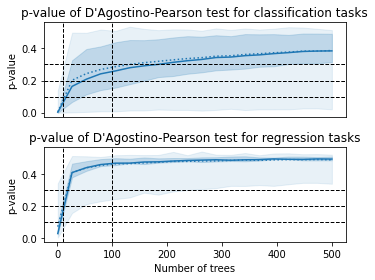

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4))

for task_type, ax in zip(["classification", "regression"], axs):
    df = pd.read_csv(f"pvals_{task_type}.csv").dropna()
    df["forest_sizes"] = [json.loads(e) for e in df["forest_sizes"]]
    pvals = [json.loads(e) for e in df["pvalues"]]
    df["pvalues"] = pvals

    forest_sizes = df.iloc[0]["forest_sizes"]
    mean_pvals = np.mean(pvals, axis = 1)
    print(f"Aggregating over {mean_pvals.shape[0]} datasets.")

    ax.plot(forest_sizes, mean_pvals.mean(axis=0), linestyle="dotted")
    ax.fill_between(forest_sizes, np.percentile(mean_pvals, 25, axis=0), np.percentile(mean_pvals, 75, axis=0), alpha=0.2, color=f"C{0}")
    ax.fill_between(forest_sizes, np.percentile(mean_pvals, 1, axis=0), np.percentile(mean_pvals, 99, axis=0), alpha=0.1, color=f"C{0}")
    ax.plot(forest_sizes, np.median(pvals, axis=1).mean(axis=0), color=f"C{0}")
    for threshold in [0.1, 0.2, 0.3]:
        ax.axhline(threshold, color="black", linestyle="--", linewidth=1)
    ax.axvline(10, color="black", linestyle="--", linewidth=1)
    ax.axvline(100, color="black", linestyle="--", linewidth=1)

    ax.set_xlabel("Number of trees")
    ax.set_ylabel("p-value")
    ax.set_title(f"p-value of D'Agostino-Pearson test for {task_type} tasks")

axs[0].set_xticks([])
axs[0].set_xlabel(None)
fig.tight_layout()
fig.savefig("plots/pvals.pdf", bbox_inches="tight")

## Tests that Variance is within Proven Bounds

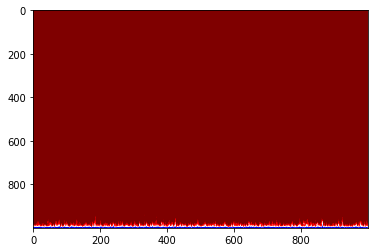

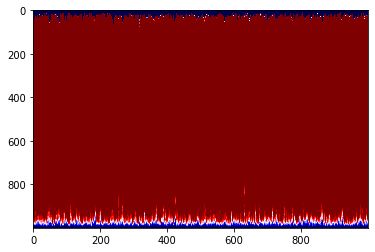

0.020358120189703774


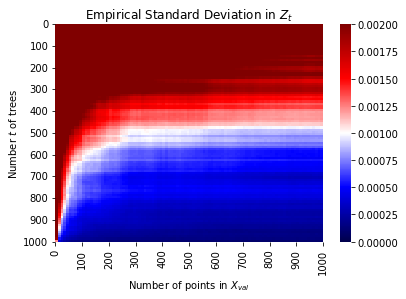

In [15]:
create_std_plots(openmlid=1485)

## Show Standard-Dev as a function of t assuming 80% for training and 20% for testing
Plot shows this for all datasets.

In [16]:
stds = pd.read_csv("curvestds.csv").drop(columns=["openmlid"]).values
stds.shape

(222, 2000)

In [17]:
def plot_stds(task_type, stds, scale = 0.8, ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(scale * 5,  scale * 2))
    else:
        fig = None
    print(f"Plotting summary of {len(stds)} {task_type} datasets.")
    ax.plot(range(stds.shape[-1]), stds.mean(axis=0))
    ax.fill_between(range(stds.shape[-1]), stds.min(axis=0), stds.max(axis=0), color="C0", alpha=0.1)
    ax.fill_between(range(stds.shape[-1]), np.percentile(stds, 25, axis=0), np.percentile(stds, 75, axis=0), color="C0", alpha=0.2)
    ax.axhline(0.0, color="black")
    #ax.axhline(0.003, color="black", linestyle="--")
    ax.axhline(0.001, color="black", linestyle="--", linewidth=1)
    ax.axvline(100, color="black", linestyle="--", linewidth=1)
    ax.axvline(500, color="black", linestyle="--", linewidth=1)
    ax.axvline(1000, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("t")
    ax.set_ylabel("std ($Z_t$)")
    ax.set_ylim([0, 0.005])
    
    if fig is not None:
        fig.savefig(f"plots/stds_by_numtrees_over_datasets_{task_type}.pdf", bbox_inches="tight")

In [18]:
stds = pd.read_csv("curvestds.csv")
scale = 1

Plotting summary of 176 classification datasets.
Plotting summary of 47 regression datasets.


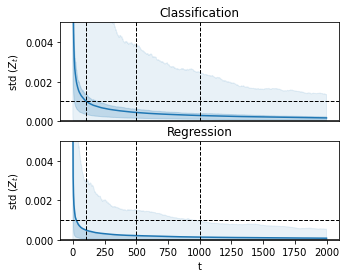

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(scale * 5,  scale * 4))
plot_stds("classification", stds[stds["openmlid"].isin(datasets_classification)].drop(columns=["openmlid"]).values.astype(float), ax = axs[0])
plot_stds("regression", stds[stds["openmlid"].isin(datasets_regression)].drop(columns=["openmlid"]).values.astype(float), ax=axs[1])
axs[0].set_title("Classification")
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[1].set_title("Regression")
fig.savefig("plots/stds_by_numtrees_over_datasets.pdf", bbox_inches="tight")